# Gaurav Mishra November 10, CS7180


In [7]:
################CHANGE PATH BELOW#########################
PATH = '/Users/gaurav/Desktop/AdvancedPerception/TimeSequences'
#change it to wherever this notebook is stored
###############CHANGE PATH ABOVE##########################
%cd $PATH

/Users/gaurav/Desktop/AdvancedPerception/TimeSequences


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import glob
#import librosa as lbr
#from librosa.feature import mfcc
#from alive_progress import alive_bar

#!pip install keras
#!pip install https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.8.0-py3-none-any.whl
#!pip install deep_xf
#from deep_xf.denoise import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, top_k_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Generating time domain and frequency domain features from the ECG signals

First using the filters such as high pass and lpf filters trying to clean the ECG signals

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import warnings

warnings.filterwarnings('ignore')


def get_time_series_features(signal):
    window_size = len(signal)
    # mean
    sig_mean = np.mean(signal)
    # standard deviation
    sig_std = np.std(signal)
    # avg absolute difference
    sig_aad = np.mean(np.absolute(signal - np.mean(signal)))
    # min
    sig_min = np.min(signal)
    # max
    sig_max = np.max(signal)
    # max-min difference
    sig_maxmin_diff = sig_max - sig_min
    # median
    sig_median = np.median(signal)
    # median absolute deviation
    sig_mad = np.median(np.absolute(signal - np.median(signal)))
    # Inter-quartile range
    sig_IQR = np.percentile(signal, 75) - np.percentile(signal, 25)
    # negative count
    sig_neg_count = np.sum(s < 0 for s in signal)
    # positive count
    sig_pos_count = np.sum(s > 0 for s in signal)
    # values above mean
    sig_above_mean = np.sum(s > sig_mean for s in signal)
    # number of peaks
    sig_num_peaks = len(find_peaks(signal)[0])
    # skewness
    sig_skew = stats.skew(signal)
    # kurtosis
    sig_kurtosis = stats.kurtosis(signal)
    # energy
    sig_energy = np.sum(s ** 2 for s in signal) / window_size
    # signal area
    sig_sma = np.sum(signal) / window_size

    return [sig_mean, sig_std, sig_aad, sig_min, sig_max, sig_maxmin_diff, sig_median, sig_mad, sig_IQR, sig_neg_count, sig_pos_count, sig_above_mean, sig_num_peaks, sig_skew, sig_kurtosis, sig_energy, sig_sma]
#The code for feature processing and signal denoising is courtesy of Varun Mishra

def get_freq_domain_features(signal):
    all_fft_features = []
    window_size = len(signal)
    signal_fft = np.abs(np.fft.fft(signal))
    # Signal DC component
    sig_fft_dc = signal_fft[0]
    # aggregations over the fft signal
    fft_feats = get_time_series_features(signal_fft[1:int(window_size / 2) + 1])

    all_fft_features.append(sig_fft_dc)
    all_fft_features.extend(fft_feats)
    return all_fft_features


In [4]:
data_all = pd.read_csv('data/all_data_with_subject_info.csv', index_col=0);
data_all = data_all.sample(frac=1, random_state=123).reset_index(drop=True);

n_train = int(len(data_all)*0.7);
n_val = len(data_all) - n_train;

data_train = data_all.iloc[0:n_train,:];
data_val = data_all.iloc[n_train:,:];

x_train = data_train.iloc[:,:-1]
#x_train=pd.read_csv('../x_train.csv')
y_train = data_train.iloc[:,data_train.shape[1]-1];

x_val = data_val.iloc[:,:-1]
#x_val = pd.read_csv('../x_val.csv')
y_val = data_val.iloc[:,data_val.shape[1]-1];


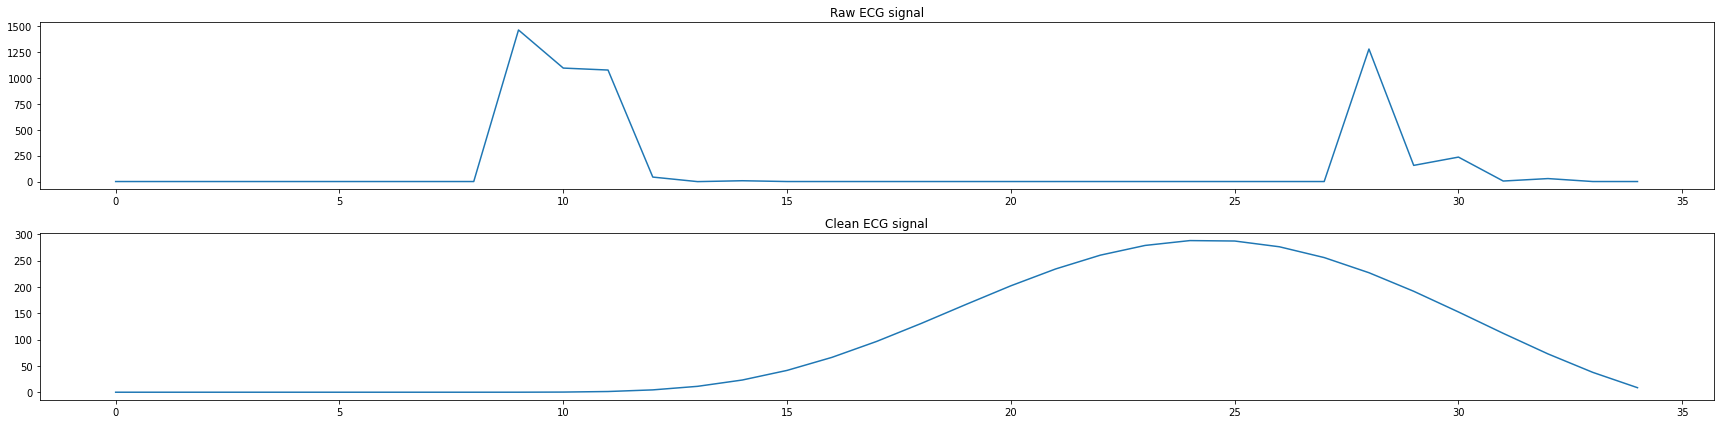

In [5]:
import scipy
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
## A high pass filter allows frequencies higher than a cut-off value

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba')
    return b, a
## A low pass filter allows frequencies lower than a cut-off value
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba')
    return b, a
def notch_filter(cutoff, q):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a

def highpass(data, fs, order=5):
    b,a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b,a,data)
    return x

def lowpass(data, fs, order =5):
    b,a = butter_lowpass(cutoff_low, fs, order=order)
    y = lfilter(b,a,data)
    return y

def notch(data, powerline, q):
    b,a = notch_filter(powerline,q)
    z = lfilter(b,a,data)
    return z

def final_filter(data, fs, order=5):
    b, a = butter_highpass(cutoff_high, fs, order=order)
    x = lfilter(b, a, data)
    d, c = butter_lowpass(cutoff_low, fs, order = order)
    y = lfilter(d, c, x)
    f, e = notch_filter(powerline, 30)
    z = lfilter(f, e, y)     
    return z

orignal_fs = 360

fs = 512
#ecg_signal = scipy.signal.resample(ecg_signal_data, num=fs*60*5)[:1280]
# ecg_signal.shape

## Order of five works well with ECG signals
cutoff_low = 20
cutoff_high = 0.5
powerline = 50
order = 5

#plottinga few ECGs
plt.figure(1, figsize=(24,6))
ax1 = plt.subplot(211)
plt.plot(x_train.iloc[50010,:].values)
ax1.set_title("Raw ECG signal")

filter_signal = final_filter(x_train.iloc[50010,:].values, fs, order)
ax2 = plt.subplot(212)
plt.plot(filter_signal)
ax2.set_title("Clean ECG signal")
plt.tight_layout()
plt.show()

In [6]:
for i in range(len(x_train)):
    x_train.iloc[i,:] = final_filter(x_train.iloc[i,:],fs,order);
for i in range(len(x_val)):
    x_val.iloc[i,:] = final_filter(x_val.iloc[i,:],fs,order);

In [19]:
features_train = []
for i in range(len(x_train)):
    temp_features=[]
    temp_features.extend(get_time_series_features(x_train.iloc[i,:]))
    temp_features.extend(get_freq_domain_features(x_train.iloc[i,:]))
    features_train.append(temp_features)

In [20]:
features_val = []
for i in range(16400):
    temp_features=[]
    temp_features.extend(get_time_series_features(x_val.iloc[i,:]))
    temp_features.extend(get_freq_domain_features(x_val.iloc[i,:]))
    features_val.append(temp_features)

In [21]:
class_weight = {0: 20.,
                1: 20.,
                2: 20.,
                3: 20.,
                4: 20.,
                5: 20.,
                6: 15.,
                7: 20.}

# Trying Machine Learning methods

Thoughts on results: There are obvious signs of overfitting but I have not tried to regularize the model since that is beyond the scope of this assignment. The validation accuracy of 94% is still a good one.

In [36]:
rf = RandomForestClassifier()
rf.fit(features_train, y_train)

RandomForestClassifier()

In [35]:
len(y_train)

326862

In [37]:
y_pred = rf.predict(features_train)
len(y_pred)
print(classification_report(y_train,y_pred))#, labels=label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12980
           1       1.00      1.00      1.00      1961
           2       1.00      1.00      1.00     76886
           3       1.00      1.00      1.00     24432
           4       1.00      1.00      1.00     73065
           5       1.00      1.00      1.00     31808
           6       1.00      1.00      1.00     96594
           7       1.00      1.00      1.00      9136

    accuracy                           1.00    326862
   macro avg       1.00      1.00      1.00    326862
weighted avg       1.00      1.00      1.00    326862



In [43]:
y_pred = rf.predict(features_val)
print(classification_report(y_val[0:16400],y_pred))

              precision    recall  f1-score   support

           0       0.91      0.58      0.71       668
           1       0.94      0.65      0.77       102
           2       0.86      0.89      0.88      3892
           3       0.83      0.81      0.82      1284
           4       0.83      0.84      0.83      3629
           5       0.87      0.86      0.87      1554
           6       0.89      0.92      0.91      4810
           7       0.88      0.82      0.85       461

    accuracy                           0.86     16400
   macro avg       0.88      0.80      0.83     16400
weighted avg       0.86      0.86      0.86     16400



In [ ]:
sv =SVC()
sv.fit(features_train, y_train)

y_pred = sv.predict(features_train)
print(classification_report(y_train,y_pred))#labels=label))
y_pred = sv.predict(features_val)
print(classification_report(y_val[0:5138],y_pred))#labels=label))

In [41]:
label = ['normal','brux','ins','narco','nfle','plm','rbd', 'sdb']